## Shortest Paths with NetworkX and OpenStreetMap Data  
### Overpass API Method

This implementation takes the following approach:
* Download data with the get_osm_data module, which uses the Overpass API. The Overpass API may be limited to relatively small map areas.
* Convert downloaded data into a NetworkX graph object with the get_osm_data module.
* Use a shortest path algorithm already implemented in NetworkX to find the shortest path between two nodes.

References:
* NetworkX tutorial https://networkx.readthedocs.org/en/latest/tutorial/tutorial.html#nodes.
* Possible alternative methods to query Overpass API: https://github.com/mvexel/overpass-api-python-wrapper and https://github.com/DinoTools/python-overpy.

Conclusions:
* Obtaining data using the Overpass API isn't likely viable for all but small map areas.

In [2]:
import get_osm_data
import networkx as nx
from haversine import haversine

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Download a very small example map from OSM

Use code in get_osm_data to (1) download an OSM file using the Overpass API and then (2) create a NetworkX graph object from the downloaded data.

In [8]:
roads = 'motorway|trunk|primary|secondary|tertiary|road|residential|service|motorway_link|trunk_link|primary_link|secondary_link|teriary_link'
coords = (-88.82289, 43.49353, -88.81792, 43.49563)

OSM map for the example coordinates:
https://www.openstreetmap.org/#map=18/43.49461/-88.82063

In [9]:
args = coords + (roads,)
map = get_osm_data.download_osm(*args)

trying to download osm data from -88.82289 43.49353 -88.81792 43.49563 with highways of categoriesmotorway|trunk|primary|secondary|tertiary|road|residential|service|motorway_link|trunk_link|primary_link|secondary_link|teriary_link
downloading osm data from -88.82289 43.49353 -88.81792 43.49563 with highways of categoriesmotorway|trunk|primary|secondary|tertiary|road|residential|service|motorway_link|trunk_link|primary_link|secondary_link|teriary_link


In [10]:
G = get_osm_data.read_osm(map)

### Take a look at the graph

In [11]:
# Basic info about the graph:
G.number_of_nodes(), G.number_of_edges()

(55, 112)

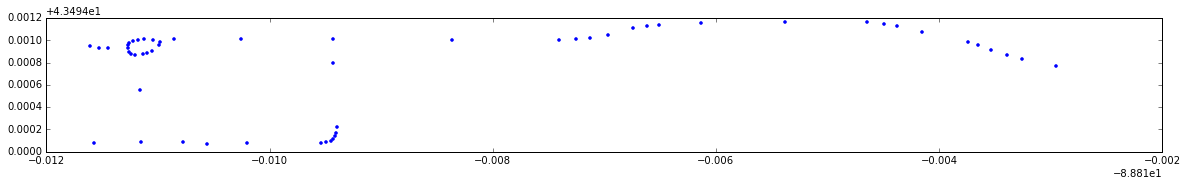

In [12]:
# Plot the data: the OSM map linked above is basically recognizable.
# Longitude is an East-West coordinate
# Latitude is North-South coordinate
fig = plt.figure(figsize=(20, 20))  # a new figure window
ax = fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
ax.plot([G.node[n]['lon'] for n in G], [G.node[n]['lat'] for n in G], '.')
ax.set_aspect(aspect='equal')

### Assign edge weights
Assign a weight to every edge in the graph. This is probably a really inefficient way of assigning edge weights. A better way might be to assign a weight only if the edge is examined in a shortest paths algorithm.

In [13]:
def calc_distance(node0, node1):
    # Return distance between two nodes in meters
    lat0 = node0['lat']
    lon0 = node0['lon']
    lat1 = node1['lat']
    lon1 = node1['lon']
    return 1000* haversine((lat0, lon0), (lat1, lon1), miles = False)    

In [14]:
for node0, node1 in G.edges_iter():
    G[node0][node1]['distance'] = calc_distance(G.node[node0], G.node[node1])

### Find a shortest path

Currently the nodes don't have meaningful names, i.e. there aren't nodes with names of cities, intersections, etc. Nodes must be accessed by their unique ids.

In [22]:
start_node = '2762651306'
end_node = '230757310'
ends = (start_node, end_node)

In [23]:
path = nx.dijkstra_path(G, start_node, end_node, weight='distance')

In [24]:
path_length = nx.dijkstra_path_length(G, start_node, end_node, weight='distance')
path_length

330.2584885719308

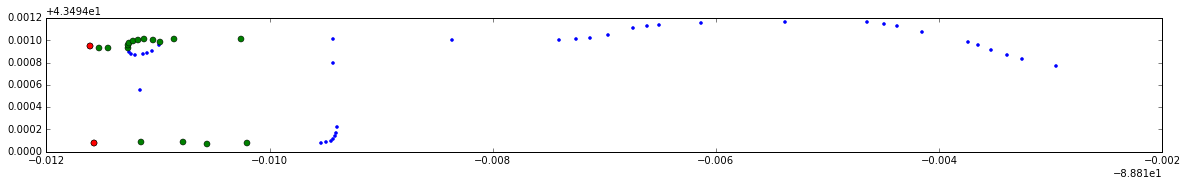

In [25]:
fig = plt.figure(figsize=(20, 20))  # a new figure window
ax = fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
ax.plot([G.node[n]['lon'] for n in G], [G.node[n]['lat'] for n in G], '.')
ax.plot([G.node[n]['lon'] for n in path], [G.node[n]['lat'] for n in path], 'o')
ax.plot([G.node[n]['lon'] for n in ends], [G.node[n]['lat'] for n in ends], 'o')
ax.set_aspect(aspect='equal')

This solution is deceiving because it seems like the green points don't indicate the shortest path between the red points. Look at the OSM [map link](https://www.openstreetmap.org/#map=18/43.49461/-88.82063) to see why! (The leftmost vertical street doesn't go through; this would be obvious if the plot above showed edges.)